In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Cargamos el dataset


In [2]:
df = pd.read_csv('./data/daily_hospitalized_patients.csv', parse_dates=['date'])
df = df.sort_values('date')


## Preparación de la serie temporal


In [3]:
# Serie objetivo
y = df['num_patients'].values

# Para ARIMA no necesitamos escalar, pero mantenemos el scaler para inversión si es necesario
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Cantidad de valores pasados que usaremos como referencia
N_LAGS = 14


# ARIMA sin variables exogenas


## Entrenamiento del modelo


Horizonte 1 días → MAE = 10.603, R² = 0.708
Horizonte 2 días → MAE = 14.512, R² = 0.471
Horizonte 3 días → MAE = 17.922, R² = 0.237
Horizonte 4 días → MAE = 20.552, R² = -0.009
Horizonte 5 días → MAE = 22.819, R² = -0.166
Horizonte 6 días → MAE = 24.669, R² = -0.323
Horizonte 7 días → MAE = 25.480, R² = -0.470


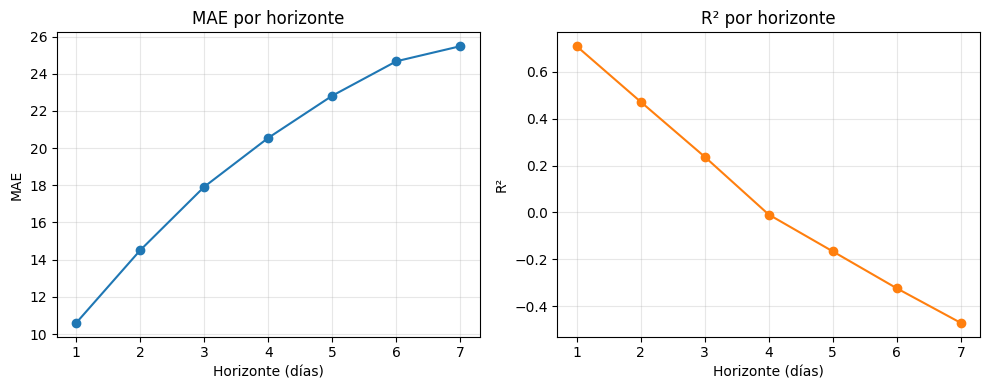

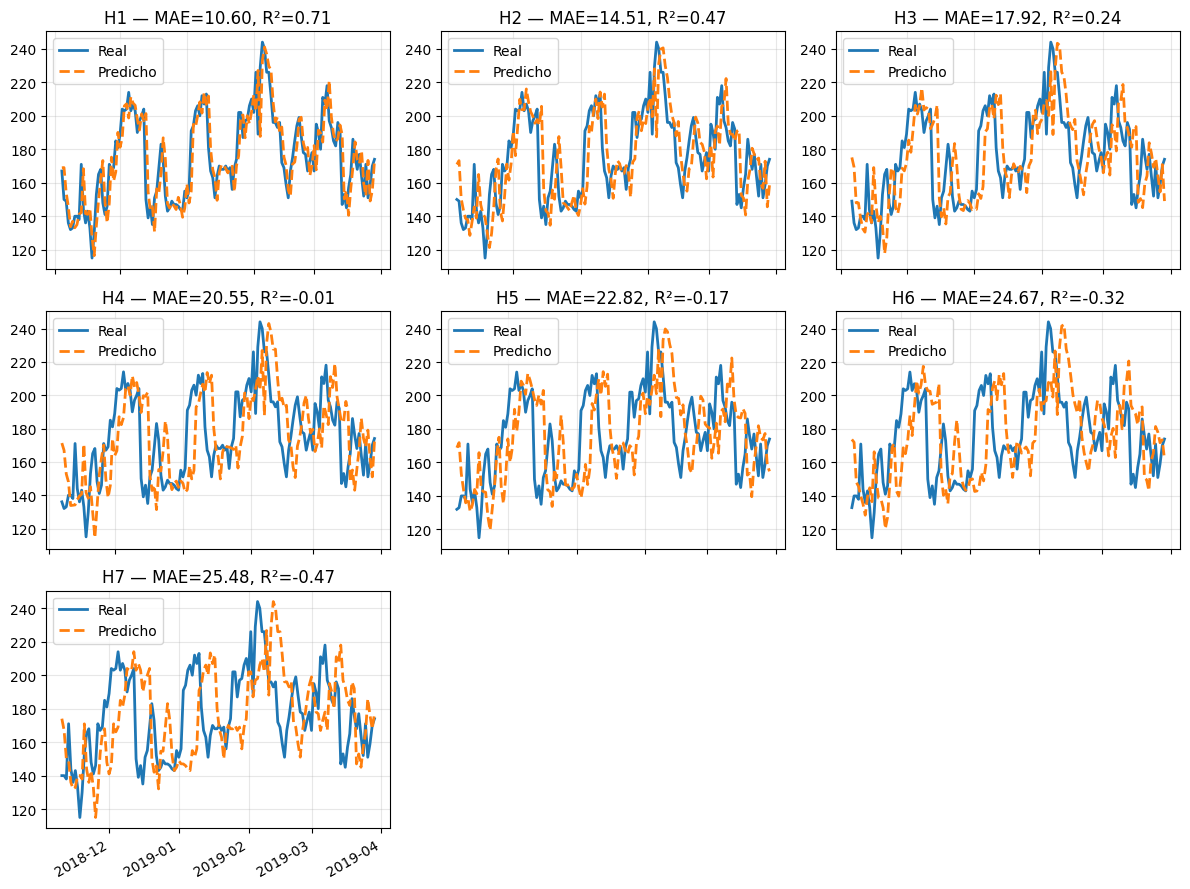

In [6]:
horizontes = range(1, 8)  # 1..7
mae_por_h = []
r2_por_h = []
modelos = {}
results_by_h = {}

# Split 80/20
split = int(len(y) * 0.8)
y_train = y[:split]
y_test = y[split:]
test_dates_base = df['date'].reset_index(drop=True).iloc[split:].values

for h in horizontes:
    # Para ARIMA, entrenamos con datos hasta el split y predecimos h pasos adelante
    # Necesitamos hacer predicciones paso a paso para cada punto del test
    
    try:
        # Predecir para el conjunto de test
        # Necesitamos predecir h pasos adelante para cada punto
        Y_pred = []
        Y_test = []
        
        # Hacer predicciones recursivas
        # Limitamos el rango para asegurar que siempre tengamos datos suficientes
        max_iterations = len(y_test) - h + 1
        
        current_data = y_train.copy()
        for i in range(max_iterations):
            # Ajustar modelo con datos hasta el punto actual
            if i > 0:
                current_data = np.append(current_data, y_test[i-1])
            
            # Ajustar modelo
            model = ARIMA(current_data, order=(2, 1, 2))
            fitted = model.fit()
            
            # Predecir h pasos adelante
            forecast = fitted.forecast(steps=h)
            Y_pred.append(forecast[-1])  # Tomamos el último valor (h pasos adelante)
            
            # Valor real correspondiente (siempre i + h - 1 porque limitamos max_iterations)
            Y_test.append(y_test[i + h - 1])
        
        Y_pred = np.array(Y_pred)
        Y_test = np.array(Y_test)
        
        # Asegurar que tienen la misma longitud
        min_len = min(len(Y_pred), len(Y_test))
        Y_pred = Y_pred[:min_len]
        Y_test = Y_test[:min_len]
        
        # Ajustar fechas para este horizonte
        test_indices = np.arange(split + h - 1, split + h - 1 + len(Y_test))
        test_dates = df['date'].reset_index(drop=True).iloc[test_indices].values
        
        # Métricas: MAE + R²
        mae = mean_absolute_error(Y_test, Y_pred)
        try:
            r2 = r2_score(Y_test, Y_pred)
        except Exception:
            r2 = float('nan')
        
        mae_por_h.append(mae)
        r2_por_h.append(r2)
        
        print(f"Horizonte {h} días → MAE = {mae:.3f}, R² = {r2:.3f}")
        
        # Guardar resultados para graficar
        results_by_h[h] = {
            "dates": test_dates,
            "y_true": Y_test,
            "y_pred": Y_pred,
            "mae": mae,
            "r2": r2
        }
        
        modelos[h] = fitted
        
    except Exception as e:
        print(f"Error entrenando horizonte {h}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Opcional: graficar degradación MAE y R²
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(horizontes), mae_por_h, marker='o', color='#1f77b4')
plt.title("MAE por horizonte")
plt.xlabel("Horizonte (días)")
plt.ylabel("MAE")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(list(horizontes), r2_por_h, marker='o', color='#ff7f0e')
plt.title("R² por horizonte")
plt.xlabel("Horizonte (días)")
plt.ylabel("R²")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Panel: real vs predicho por horizonte (incluye MAE y R² en el título)
n = len(horizontes)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), squeeze=False)
axes = axes.flatten()

for idx, h in enumerate(horizontes):
    ax = axes[idx]
    if h not in results_by_h:
        ax.set_visible(False)
        continue

    res = results_by_h[h]
    ax.plot(res["dates"], res["y_true"], label="Real", color="#1f77b4", linewidth=2)
    ax.plot(res["dates"], res["y_pred"], label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"H{h} — MAE={res['mae']:.2f}, R²={res['r2']:.2f}")
    ax.grid(alpha=0.3)
    ax.legend()
    try:
        fig.autofmt_xdate()
    except Exception:
        pass

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Graficamos


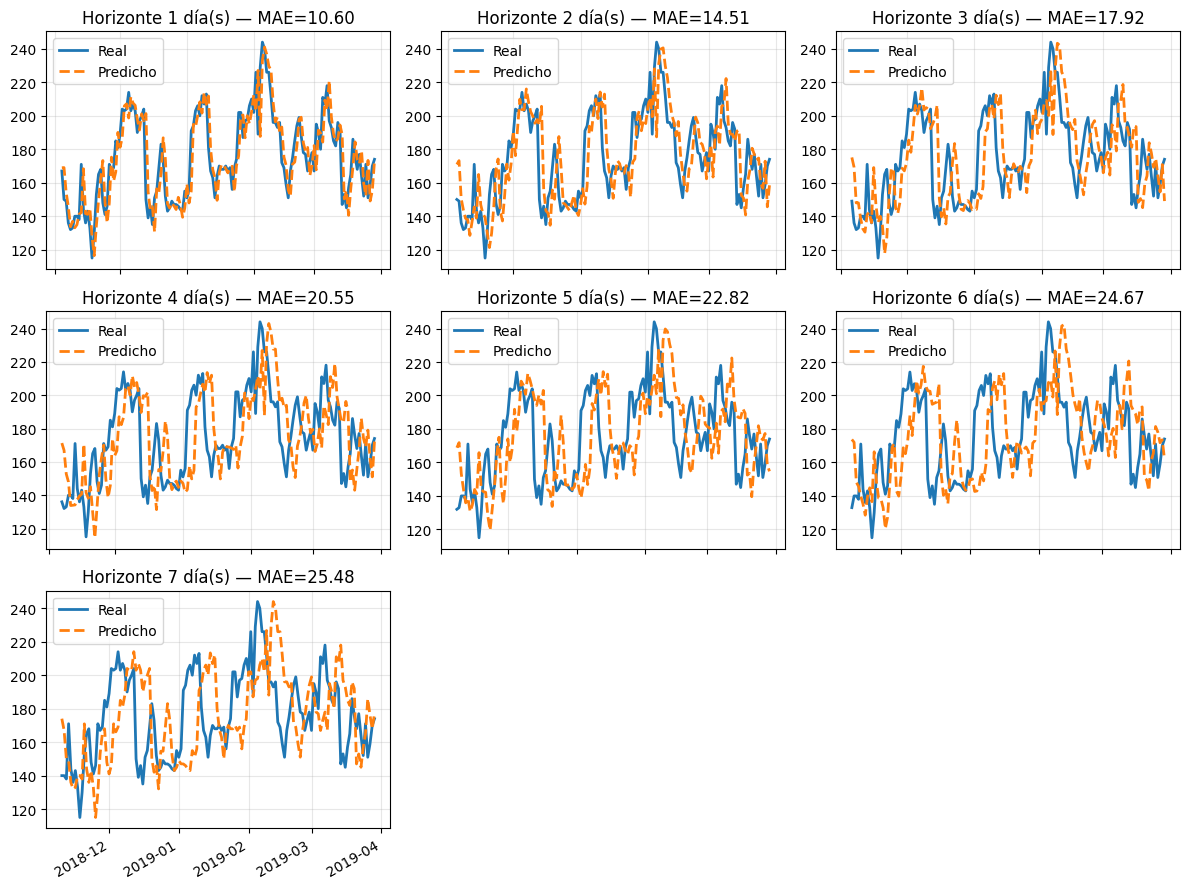

In [7]:
n = len(horizontes)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), squeeze=False)
axes = axes.flatten()

for idx, h in enumerate(horizontes):
    ax = axes[idx]
    if h not in results_by_h:
        ax.set_visible(False)
        continue

    res = results_by_h[h]
    ax.plot(res["dates"], res["y_true"], label="Real", color="#1f77b4", linewidth=2)
    ax.plot(res["dates"], res["y_pred"], label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"Horizonte {h} día(s) — MAE={res['mae']:.2f}")
    ax.grid(alpha=0.3)
    ax.legend()
    # Formato fecha si hay muchas observaciones
    try:
        fig.autofmt_xdate()
    except Exception:
        pass

# Eliminar ejes sobrantes
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# ARIMA con variables exogenas (ARIMAX)


### Preparamos las variables exogenas


In [8]:
df_weather = pd.read_csv('./data/HDHI_pollution_data.csv')
df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)


In [9]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce')

# Columnas de interés (ajusta nombres si en tu CSV son distintos)
wanted = ['DATE', 'AQI', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']
present = [c for c in wanted if c in df_weather.columns]

# Seleccionar y, si hay duplicados por fecha, agregarlos por media
dfw_sel = df_weather[present].copy()
if dfw_sel['DATE'].duplicated().any():
    dfw_sel = dfw_sel.groupby('DATE', as_index=False).mean()

# Merge por fecha (left join para conservar daily_counts)
df_exogen = pd.merge(df, dfw_sel, left_on='date', right_on='DATE', how='left')

# Limpiar/renombrar columnas para análisis posterior
df_exogen = df_exogen.drop(columns=['DATE'], errors='ignore').rename(
    columns={
        'AQI': 'aqi',
        'MAX TEMP': 'max_temp',
        'MIN TEMP': 'min_temp',
        'HUMIDITY': 'humidity'
    }
)

# Forzar numérico en las columnas añadidas
for col in ['aqi', 'max_temp', 'min_temp', 'humidity']:
    if col in df_exogen.columns:
        df_exogen[col] = pd.to_numeric(df_exogen[col], errors='coerce')


mean_humidity = df_exogen['humidity'].mean()
df_exogen['humidity'] = df_exogen['humidity'].fillna(mean_humidity).round(2)

df_exogen.head()


,date,num_patients,aqi,max_temp,min_temp,humidity
0,2017-04-01,30,52,40,24,16.0
1,2017-04-02,45,59,40,21,14.0
2,2017-04-03,65,70,39,22,14.0
3,2017-04-04,78,70,39,23,23.0
4,2017-04-05,71,88,36,20,51.0


In [10]:
df_exogen = df_exogen.sort_values('date')
# Extraemos los pacientes
y = df_exogen['num_patients'].values

# Preparar variables exógenas
exog_vars = ['aqi', 'max_temp', 'min_temp', 'humidity']
exog_data = df_exogen[exog_vars].values

# Manejar valores faltantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
exog_data = imputer.fit_transform(exog_data)


## Entrenamos el modelo


In [11]:
horizontes = range(1, 8)
mae_por_h = []
r2_por_h = []
modelos = {}
results_by_h = {}

# Split 80/20
split = int(len(y) * 0.8)
y_train = y[:split]
y_test = y[split:]
exog_train = exog_data[:split]
exog_test = exog_data[split:]
test_dates_base = df_exogen['date'].reset_index(drop=True).iloc[split:].values

for h in horizontes:
    try:
        # Predecir para el conjunto de test
        Y_pred = []
        Y_test = []
        
        # Hacer predicciones recursivas
        # Limitamos el rango para asegurar que siempre tengamos datos suficientes
        max_iterations = len(y_test) - h + 1
        
        current_data = y_train.copy()
        current_exog = exog_train.copy()
        
        for i in range(max_iterations):
            # Ajustar modelo con datos hasta el punto actual
            if i > 0:
                current_data = np.append(current_data, y_test[i-1])
                current_exog = np.vstack([current_exog, exog_test[i-1]])
            
            # Ajustar modelo
            model = SARIMAX(current_data, exog=current_exog, order=(2, 1, 2))
            fitted = model.fit(disp=False)
            
            # Predecir h pasos adelante
            # Necesitamos las variables exógenas futuras
            future_exog = exog_test[i:i+h]
            forecast = fitted.forecast(steps=h, exog=future_exog)
            Y_pred.append(forecast[-1])  # Tomamos el último valor (h pasos adelante)
            
            # Valor real correspondiente (siempre i + h - 1 porque limitamos max_iterations)
            Y_test.append(y_test[i + h - 1])
        
        Y_pred = np.array(Y_pred)
        Y_test = np.array(Y_test)
        
        # Asegurar que tienen la misma longitud
        min_len = min(len(Y_pred), len(Y_test))
        Y_pred = Y_pred[:min_len]
        Y_test = Y_test[:min_len]
        
        # Ajustar fechas para este horizonte
        test_indices = np.arange(split + h - 1, split + h - 1 + len(Y_test))
        test_dates = df_exogen['date'].reset_index(drop=True).iloc[test_indices].values
        
        # Métricas: MAE + R²
        mae = mean_absolute_error(Y_test, Y_pred)
        try:
            r2 = r2_score(Y_test, Y_pred)
        except Exception:
            r2 = float('nan')
        
        mae_por_h.append(mae)
        r2_por_h.append(r2)
        
        print(f"Horizonte {h} días → MAE = {mae:.3f}, R² = {r2:.3f}")
        
        # Guardar resultados para graficar (incluye R²)
        results_by_h[h] = {
            "dates": test_dates,
            "y_true": Y_test,
            "y_pred": Y_pred,
            "mae": mae,
            "r2": r2
        }
        
        modelos[h] = fitted
        
    except Exception as e:
        print(f"Error entrenando horizonte {h}: {e}")
        import traceback
        traceback.print_exc()
        continue


Horizonte 1 días → MAE = 10.501, R² = 0.704
Horizonte 2 días → MAE = 14.706, R² = 0.460
Horizonte 3 días → MAE = 17.971, R² = 0.232
Horizonte 4 días → MAE = 20.608, R² = -0.012
Horizonte 5 días → MAE = 22.743, R² = -0.163
Horizonte 6 días → MAE = 24.416, R² = -0.301
Horizonte 7 días → MAE = 25.286, R² = -0.450


## Graficos


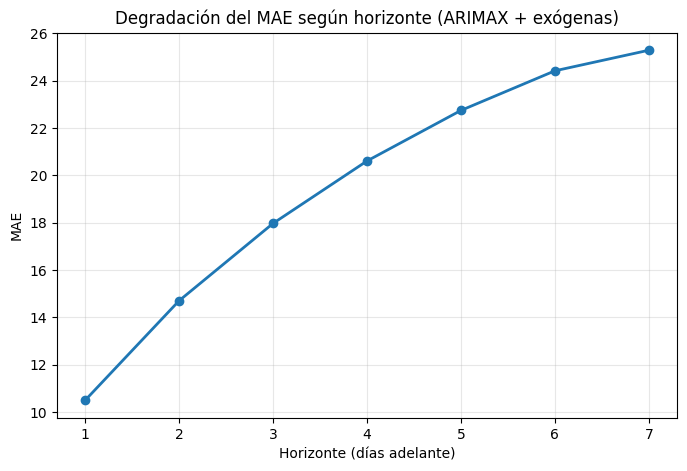

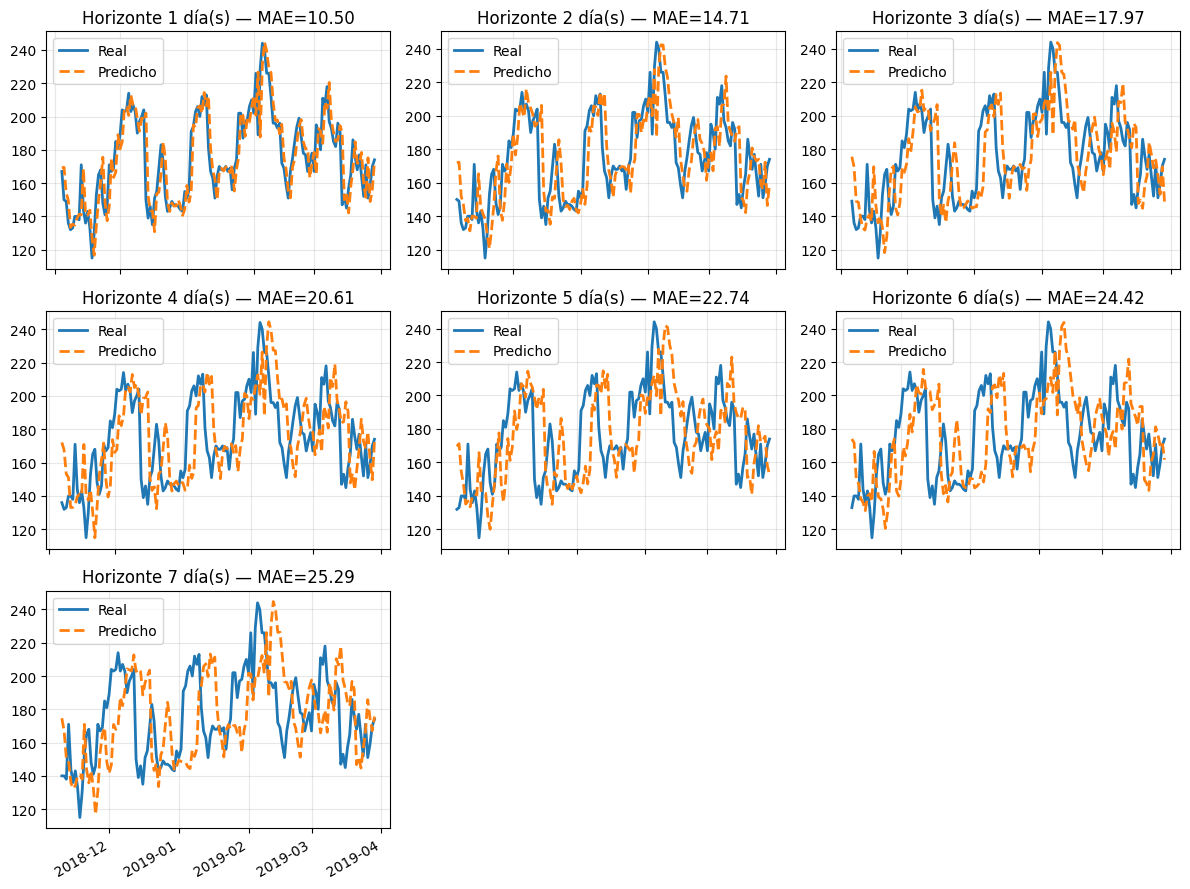

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(list(horizontes), mae_por_h, marker='o', linewidth=2, color="#1f77b4")
plt.title("Degradación del MAE según horizonte (ARIMAX + exógenas)")
plt.xlabel("Horizonte (días adelante)")
plt.ylabel("MAE")
plt.grid(alpha=0.3)
plt.show()

# Graficar cada horizonte: serie real vs predicción
n = len(horizontes)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), squeeze=False)
axes = axes.flatten()

for idx, h in enumerate(horizontes):
    ax = axes[idx]
    if h not in results_by_h:
        ax.set_visible(False)
        continue

    res = results_by_h[h]
    ax.plot(res["dates"], res["y_true"], label="Real", color="#1f77b4", linewidth=2)
    ax.plot(res["dates"], res["y_pred"], label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"Horizonte {h} día(s) — MAE={res['mae']:.2f}")
    ax.grid(alpha=0.3)
    ax.legend()
    try:
        fig.autofmt_xdate()
    except Exception:
        pass

# Eliminar ejes sobrantes si los hay
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Mejor prediccion


In [13]:
# Para ARIMA, hacemos predicción multistep directa
# Split 80/20
split = int(len(y) * 0.8)
y_train = y[:split]
y_test = y[split:]
exog_train = exog_data[:split]
exog_test = exog_data[split:]

# Ajustar modelo ARIMAX final
arimax_model = SARIMAX(y_train, exog=exog_train, order=(2, 1, 2))
fitted_model = arimax_model.fit(disp=False)

# Predecir múltiples pasos adelante
n_steps_out = 7
n_test_points = len(y_test) - n_steps_out + 1

y_pred_multistep = []
y_test_multistep = []

current_data = y_train.copy()
current_exog = exog_train.copy()

for i in range(n_test_points):
    # Ajustar modelo con datos hasta el punto actual
    if i > 0:
        current_data = np.append(current_data, y_test[i-1])
        current_exog = np.vstack([current_exog, exog_test[i-1]])
    
    # Ajustar modelo
    model = SARIMAX(current_data, exog=current_exog, order=(2, 1, 2))
    fitted = model.fit(disp=False)
    
    # Predecir n_steps_out pasos adelante
    if i + n_steps_out <= len(exog_test):
        future_exog = exog_test[i:i+n_steps_out]
        forecast = fitted.forecast(steps=n_steps_out, exog=future_exog)
        y_pred_multistep.append(forecast)
        
        # Valores reales correspondientes
        y_test_multistep.append(y_test[i:i+n_steps_out])

y_pred_multistep = np.array(y_pred_multistep)
y_test_multistep = np.array(y_test_multistep)


In [14]:
# Métricas para predicción multistep
# Calculamos MAE y R² considerando todos los pasos
y_test_flat = y_test_multistep.flatten()
y_pred_flat = y_pred_multistep.flatten()

mae = mean_absolute_error(y_test_flat, y_pred_flat)
r2 = r2_score(y_test_flat, y_pred_flat)

print(f"Evaluación en test:")
print(f"MAE = {mae:.2f}")
print(f"R²  = {r2:.3f}")


Evaluación en test:
MAE = 19.54
R²  = 0.078


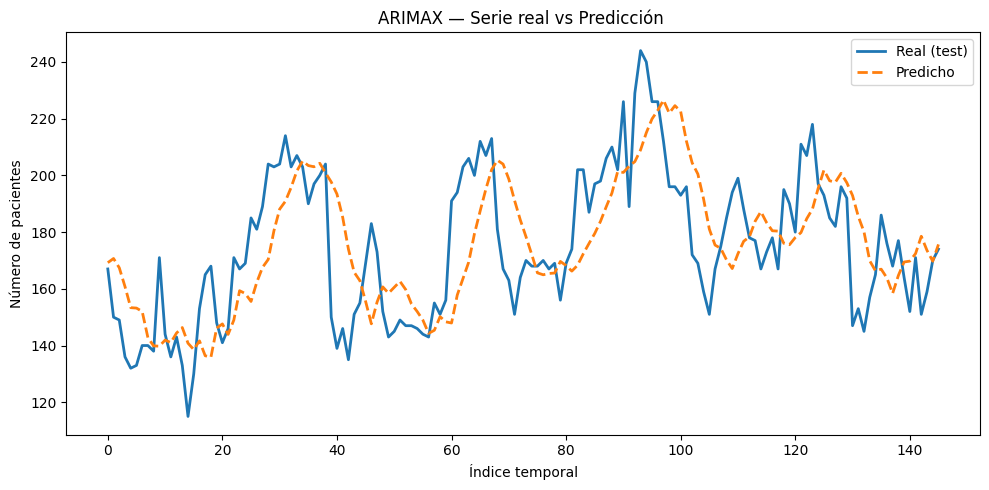

In [15]:
# --- Reconstruir serie predicha (promediando solapamientos) ---
n_test_points_recon = len(y_test_multistep) + n_steps_out - 1
y_pred_recon = np.zeros(n_test_points_recon)
counts = np.zeros(n_test_points_recon)

for i in range(len(y_pred_multistep)):
    for j in range(n_steps_out):
        y_pred_recon[i + j] += y_pred_multistep[i, j]
        counts[i + j] += 1

y_pred_recon = y_pred_recon / np.maximum(counts, 1)

# Porción real equivalente al test
y_test_segment = y_test[:len(y_pred_recon)]

# --- Graficar ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_segment, label="Real (test)", color="#1f77b4", linewidth=2)
plt.plot(y_pred_recon, label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)

plt.title("ARIMAX — Serie real vs Predicción ")
plt.xlabel("Índice temporal")
plt.ylabel("Número de pacientes")
plt.legend()
plt.tight_layout()
plt.show()
